### Problem Statement

A school district wants to compare the average math scores of two high schools (School A and School B) to see which performs better.

In [1]:
import pandas as pd
import numpy as np

# Load the CSV
df = pd.read_csv('school_math_scores.csv')

print(df.head(10))

   Student_ID School  Math_Score  Family_Income
0           1      B          83           71.6
1           2      A          91           58.3
2           3      B          86           51.7
3           4      A         100           96.9
4           5      A          90           59.2
5           6      B         100          131.1
6           7      A          79           48.4
7           8      A         100           60.2
8           9      B          82           49.7
9          10      B          65           36.2


### 1) Calculate **Raw Means** by School

In [4]:
df.groupby('School')['Math_Score'].mean()

School
A    93.204082
B    84.627451
Name: Math_Score, dtype: float64

In [6]:
print('----------------------------------')
print(f"Mean Difference: {round(df.groupby('School')['Math_Score'].mean()['A'] - df.groupby('School')['Math_Score'].mean()['B'], 2)}") 

----------------------------------
Mean Difference: 8.58


School A’s average math score is `8.6 points higher` than School B’s.

But newspapers claim that School A has more students from high-income families (who tend to have better resources). Does School A truly perform better, or is it just wealthier students?

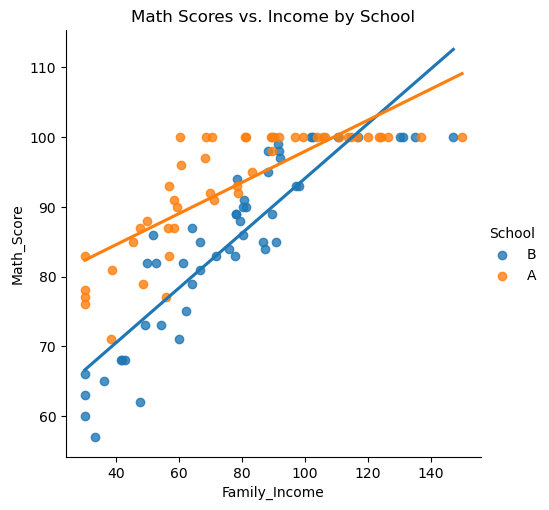

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot Math Score vs. Income, colored by School
sns.lmplot(x='Family_Income', y='Math_Score', hue='School', data=df, ci=None)
plt.title("Math Scores vs. Income by School")
plt.show()

### 2) Calculate **Adjusted Mean** (Controlling for Income)

Use a regression model to adjust for `Family_Income`:

In [13]:
import statsmodels.api as sm
model = sm.OLS.from_formula('Math_Score ~ School + Family_Income', data=df).fit()
print(model.params)

Intercept        69.509626
School[T.B]      -7.726468
Family_Income     0.300792
dtype: float64


In [15]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Math_Score   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     137.0
Date:                Sat, 26 Apr 2025   Prob (F-statistic):           5.51e-29
Time:                        15:31:05   Log-Likelihood:                -318.13
No. Observations:                 100   AIC:                             642.3
Df Residuals:                      97   BIC:                             650.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        69.5096      1.802     38.565

`School[T.B] coefficient (-7.7265)`: After accounting for income 

School B’s scores are `-7.73 points lower` than School A’s on average.

In [20]:
# Hold income/education constant at their mean values
mean_income = df['Family_Income'].mean()

# Predict adjusted means
adjusted_A = model.predict(pd.DataFrame({'School': ['A'], 'Family_Income': [mean_income]}))[0]
adjusted_B = model.predict(pd.DataFrame({'School': ['B'], 'Family_Income': [mean_income]}))[0]

print(f"Adjusted Mean (School A): {adjusted_A:.3f}")
print(f"Adjusted Mean (School B): {adjusted_B:.3f}")
print('----------------------------------')
print(f'Adjusted Mean Difference: {round(adjusted_A - adjusted_B, 2)}')

Adjusted Mean (School A): 92.770
Adjusted Mean (School B): 85.044
----------------------------------
Adjusted Mean Difference: 7.73


**Conclusion:** The `raw mean difference of 8.58 points` between School A and School B suggests that School A performs better. However, after adjusting for family income, the gap `narrows to 7.73 points`.

### 3) Plot ECDFs

Compare income distributions and check whether the curves diverge

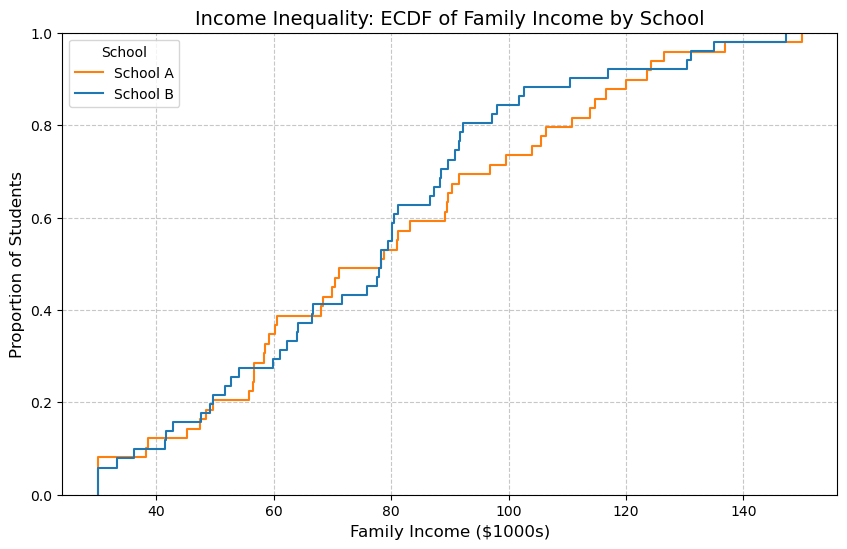

In [48]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Create ECDF plot
plt.figure(figsize=(10, 6))
sns.ecdfplot(data=df, x='Family_Income', hue='School', palette=['#1f77b4', '#ff7f0e'])
plt.title('Income Inequality: ECDF of Family Income by School', fontsize=14)
plt.xlabel('Family Income ($1000s)', fontsize=12)
plt.ylabel('Proportion of Students', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='School', labels=['School A', 'School B'])
plt.show()

warnings.resetwarnings()  # Re-enable warnings 

Interpretation:

- The curve for School A is shifted to the right of School B only around values of 100 000 family income.

- The ECDFs overlap significantly, therefore the income differences may not fully explain the score gap. 

### 4) Calculate quantiles 

Understand how income values are distributed across the dataset

In [51]:
# Quantiles of interest (e.g., 25%, 50%, 75%)
quantiles = [0.25, 0.5, 0.75, 0.9]

# Calculate quantiles for each school
quantile_data = df.groupby('School')['Family_Income'].quantile(quantiles).unstack()
print(quantile_data)

        0.25  0.50    0.75   0.90
School                           
A       56.7  78.3  103.90  120.7
B       53.4  78.2   91.15  110.5


Interpretation:

- Both schools have almost the same median income

- In general School A has more high-income families 

### 5) Kolmogorov-Smirnov test

Check if income distributions are statistically different

- `Null Hypothesis (H₀)`: Both schools’ income distributions are identical.

- `Alternative Hypothesis (H₁)`: The distributions differ.

In [37]:
from scipy import stats
ks_stat, p_value = stats.ks_2samp(
    df[df['School'] == 'A']['Family_Income'],
    df[df['School'] == 'B']['Family_Income']
)
print(f"KS Statistic: {ks_stat:.3f}, p-value: {p_value:.3f}")

KS Statistic: 0.148, p-value: 0.582


Interpretation:

- KS Statistic value (0.148) suggests a small observed difference.

- p > 0.05: Fail to reject the null hypothesis. -> No statistically significant evidence that the income distributions differ between schools.

**Overall Conclusion:**

The analysis reveals that while School A initially appears to outperform School B by 8.58 points in math scores, this gap is partially but not entirely explained by income differences.